In [2]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [6]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [7]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

False


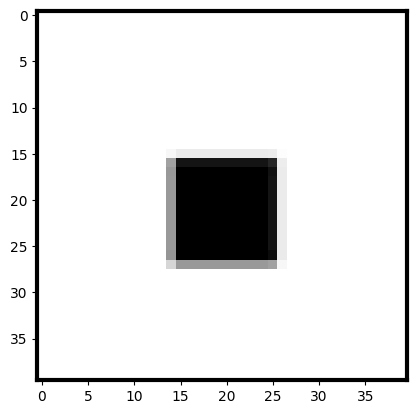

In [8]:
#will not work with mixed state probabilities
from PIL import Image
scale = 40
img = Image.open('images.png')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))

img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')

collapsed_array = np.zeros(img_array.size)

for i in range(0, img_array.size):
    collapsed_array[i] = img_array[int(i/scale)][i%scale]

test_data = np.zeros((int(img_array.size / 4), 4)) + 1j * np.zeros((int(img_array.size / 4), 4))
temp_normalize = max(collapsed_array) * 4
for i in range(0, int(img_array.size / 4)):
    test_data[i] = collapsed_array[4*i : 4*i+4] / temp_normalize + 1j * np.zeros(4)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

# Find where NaN values are
print(np.isnan(test_data).any())

# Get the indices of the NaN values
#nan_indices = np.where(img_array)

#print(nan_indices)

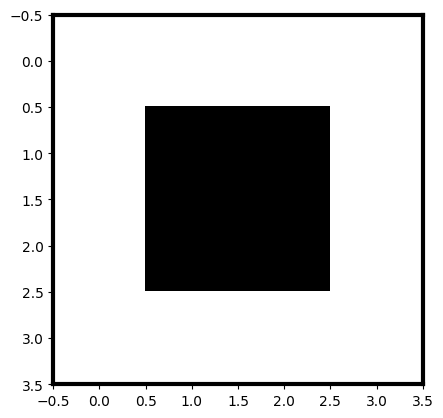

In [9]:
temp_test = np.array([[1, 1, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 1, 1]])
plt.imshow(temp_test, cmap='grey',interpolation = 'nearest')
temp_test = temp_test.flatten()


In [151]:
#generate training data for diffusion
n = 4
T = 20
Ndata = 1000

diff_hs = torch.from_numpy(np.linspace(0.5, 4., T))

model_diff = DiffusionModel(n, T, Ndata)

X = torch.from_numpy(generate_training(temp_test, Ndata, 0.1))

(1000, 16)
(16,)


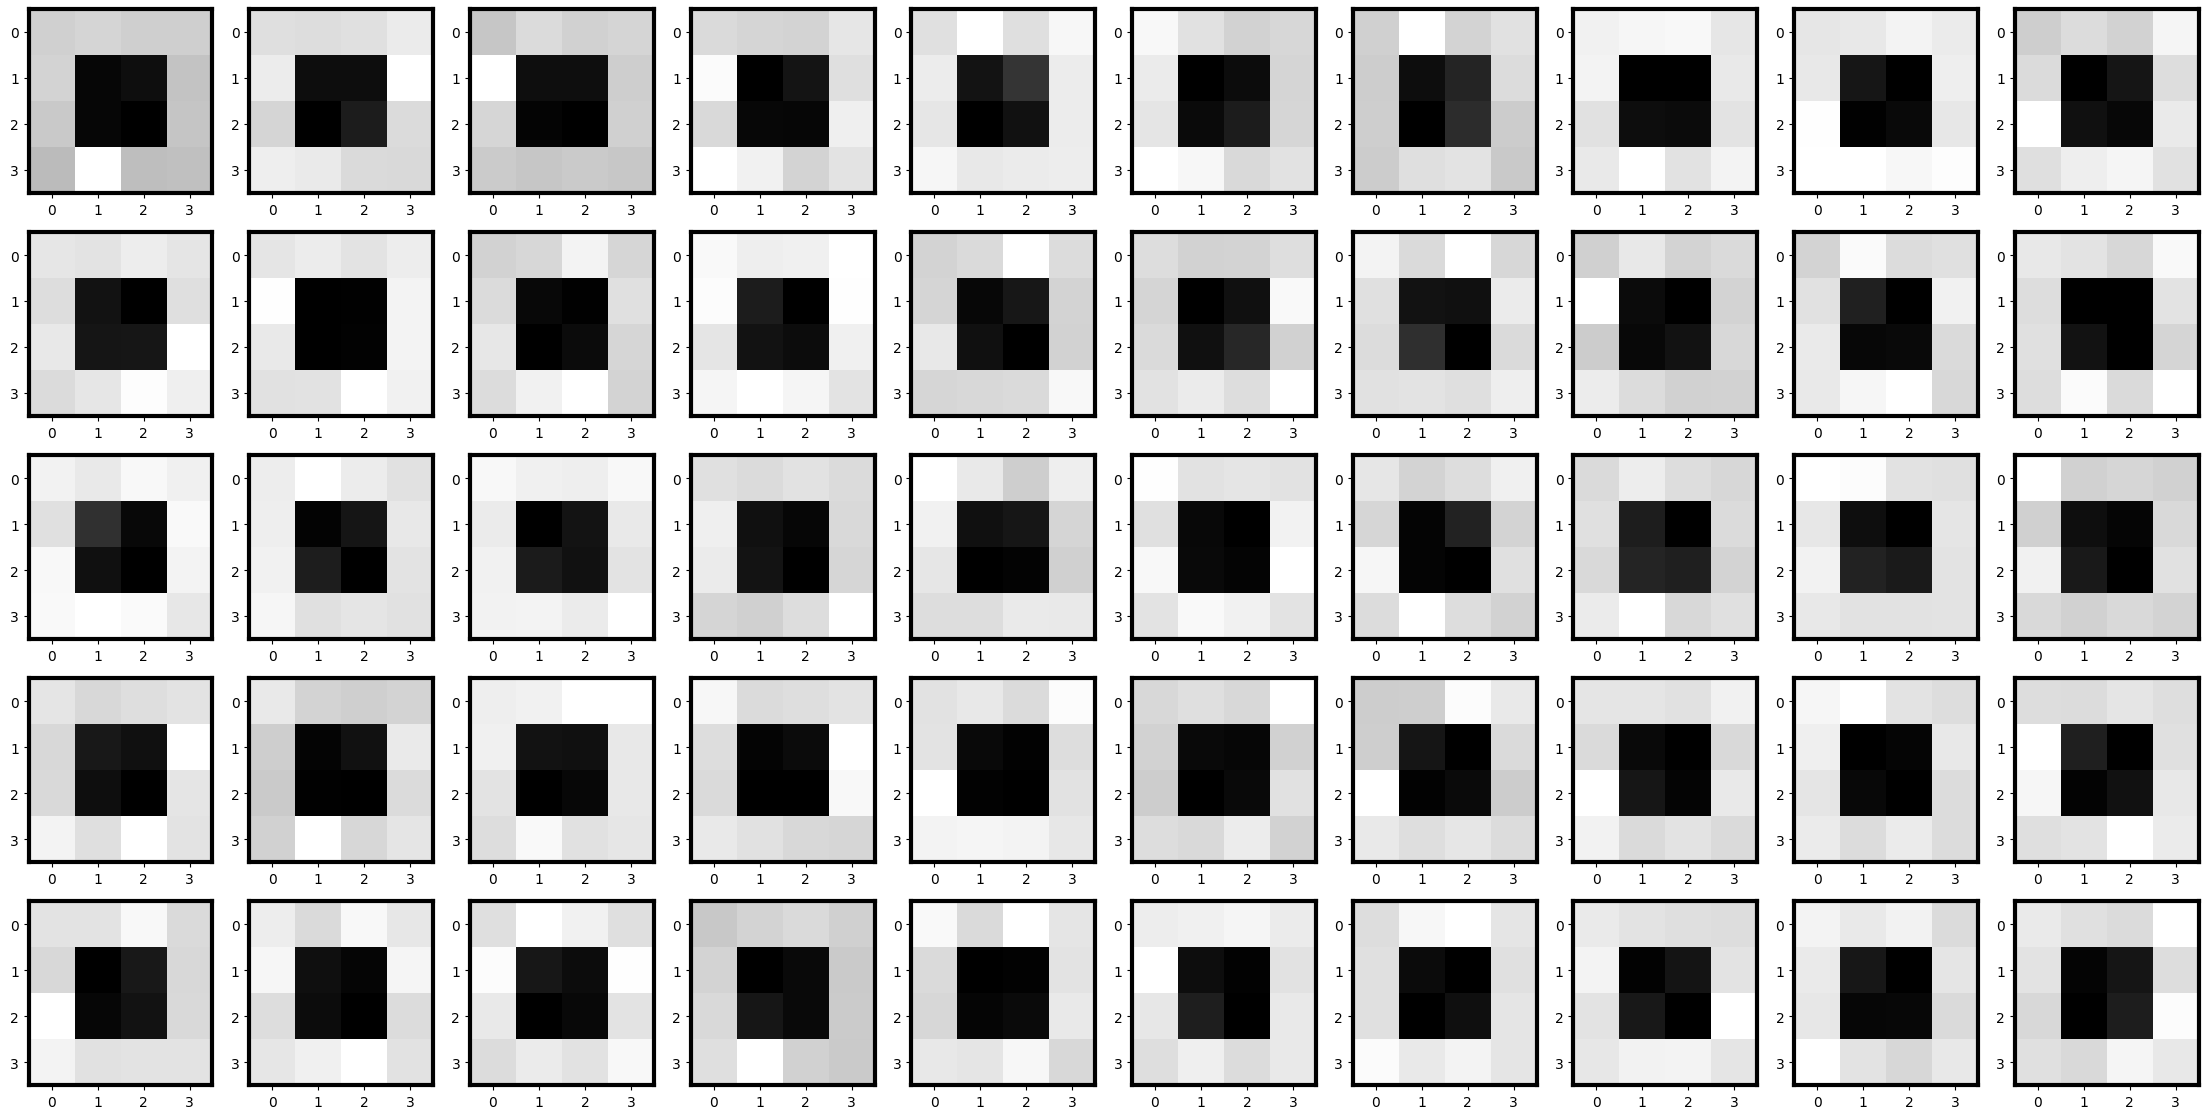

In [152]:
#visualize training data before they are forward diffused
training_temp = np.abs(np.array(X))
multiplier = np.max(training_temp)
training_temp /= multiplier
fig, axs = plt.subplots(5, 10, figsize = (28, 14))
for index_1 in range(0, 50):
    training_images = training_temp[index_1]

    picture_training  = np.zeros((4, 4))
    for i in range(0, 4):
        for j in range(0, 4):
            picture_training[i][j] = training_images[i*4 + j]

    axs[int(index_1 / 10)][index_1 % 10].imshow(picture_training, cmap='grey',interpolation = 'nearest')

In [153]:
#diffuse training data
Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X.numpy()

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

np.save("states_diff", Xout)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [154]:
from scipy.linalg import sqrtm

states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        #different calculations for mixed state fidelity
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2


fidelity_mean = np.mean(fidelity, axis = 1)
print(fidelity)

[[1.00000000e+00 9.99999881e-01 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000024e+00]
 [9.47647037e-01 9.67690975e-01 9.83941932e-01 ... 9.67807191e-01
  9.70095869e-01 9.56423347e-01]
 [9.08831801e-01 9.31428576e-01 8.38988971e-01 ... 8.13238576e-01
  8.64917973e-01 7.38518937e-01]
 ...
 [4.86056544e-05 9.29884906e-03 2.24716099e-01 ... 1.07305123e-02
  1.07919457e-01 4.79905887e-02]
 [2.64955049e-02 1.63119184e-02 7.53080010e-02 ... 5.95998355e-02
  5.57568206e-02 1.64981340e-01]
 [5.23039886e-02 5.54217712e-02 9.89114523e-02 ... 2.13310858e-04
  6.35509193e-02 3.94556608e-02]]


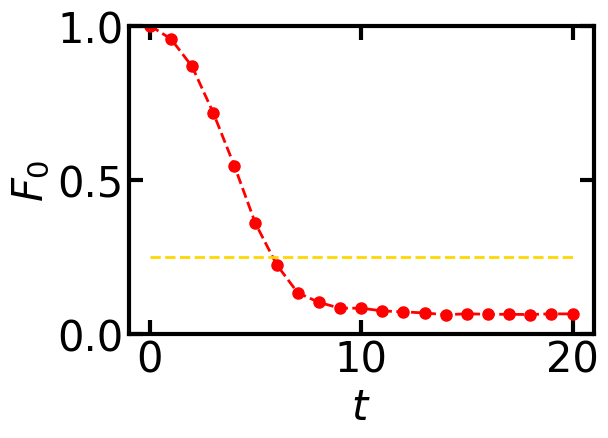

In [156]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 400
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)

ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [158]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [159]:
#train on diffusion data
n, na = 4, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 1000 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = np.load('states_diff.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('paramsandloss_squaremodel/params_t%d.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('paramsandloss_squaremodel/params_t%d'%t, params.detach().numpy())
    np.save('paramsandloss_squaremodel/loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.0114, grad_fn=<SubBackward0>), time elapsed: 0.043128013610839844 seconds
Step 100, loss: tensor(0.0070, grad_fn=<SubBackward0>), time elapsed: 3.9887053966522217 seconds
Step 200, loss: tensor(0.0041, grad_fn=<SubBackward0>), time elapsed: 7.640142202377319 seconds
Step 300, loss: tensor(0.0031, grad_fn=<SubBackward0>), time elapsed: 11.269063234329224 seconds
Step 400, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 14.88301968574524 seconds
Step 500, loss: tensor(0.0020, grad_fn=<SubBackward0>), time elapsed: 18.814587116241455 seconds
Step 600, loss: tensor(0.0015, grad_fn=<SubBackward0>), time elapsed: 22.39889645576477 seconds
Step 700, loss: tensor(0.0019, grad_fn=<SubBackward0>), time elapsed: 26.04587149620056 seconds
Step 800, loss: tensor(0.0017, grad_fn=<SubBackward0>), time elapsed: 30.05893301963806 seconds
Step 900, loss: tensor(0.0014, grad_fn=<SubBackward0>), time elapsed: 33.68143367767334 seconds
Step 1000, loss: tensor(0.0017, grad

In [160]:
n, na = 4, 1
T = 20
L = 6
Ndata = 1000
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('paramsandloss_squaremodel/params_t%d.npy'%t)
    loss_tot[t] = np.load('paramsandloss_squaremodel/loss_t%d.npy'%t)
    

np.save("params_total", params_tot)
np.save("loss_tot", loss_tot)                            

In [161]:
#Diffuse our test image
n = 4
T = 20
Ndata = 10

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)

diffuse_square = np.zeros((Ndata, 2**n)) + 1j * np.zeros((Ndata, 2**n))
for i in range(0, Ndata):
    diffuse_square[i] = np.array(temp_test / (12**0.5)) + 1j * np.zeros(2**n)

X = torch.from_numpy(diffuse_square)

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

print(Xout[20])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[-0.31829843+0.06766371j -0.06395622+0.01362468j  0.24349391+0.00807805j
   0.06059067-0.06392578j  0.18225871+0.19383447j -0.01617496-0.16060227j
   0.03917251-0.12140091j  0.11339116+0.07055244j  0.3405344 -0.04237456j
  -0.31026217+0.16271017j -0.02337476-0.05280008j  0.16326684-0.10138813j
   0.41827464-0.26867944j -0.15074214+0.24933943j -0.0529106 +0.14374685j
   0.23558295-0.00136583j]
 [-0.19480994+0.19594207j  0.02130454-0.31193215j  0.18514574+0.02469395j
   0.12794372+0.09902805j -0.24139872-0.02122208j -0.24654329-0.2531013j
  -0.363748  -0.03961353j  0.02435159+0.02852727j -0.22399493-0.08404831j
   0.24482529-0.00402174j -0.1282796 +0.11000956j  0.22934288+0.23073384j
  -0.00816752+0.12541398j  0.02978011+0.00948529j  0.29025665+0.28136355j
   0.11697067-0.02286922j]
 [-0.1911972 +0.1729475j  -0.06650671-0.15143637j  0.08699133+0.2503858j
  -0.08486635+0.31844866j  0.0437709 -0.12054489j  0.00557661+0.19806731j
   0.1996

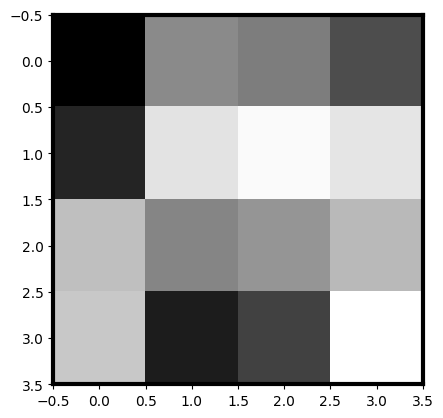

In [85]:
#create random 16 pixel data
Ndata = 100
random_images = np.zeros((Ndata, 4, 4))
amplitude_vals = np.zeros(Ndata)

for i in range(0, Ndata):
    random_images[i] = np.random.rand(4,4)
    amplitude_vals[i] = np.sum(random_images[i] ** 2) ** 0.5

plt.imshow(random_images[1], cmap = 'grey', interpolation = 'nearest')

In [ ]:
#Turn image data into qubits
random_images_qubits = np.zeros((Ndata, 4, 4))
for i in range(0, Ndata):
    random_images_qubits[i] = random_images[i] / amplitude_vals[i] + 0j
    


In [134]:
#use model to predict what original image was from diffused image
test_data_T20 = torch.tensor(Xout[20], dtype = torch.complex64)
print(test_data_T20)
n, na = 4, 1
T = 20
L = 6
Ndata = 10

diffModel = DiffusionModel(n, T, Ndata)

params_tot = np.load('params_total.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_te = model.backDataGeneration(test_data_T20, params_tot, Ndata)[:, :, :2**n].numpy()

np.save("test_backwardsgen", data_te)

tensor([[-0.0483+2.7850e-01j, -0.2158+2.0376e-02j, -0.3424-2.1568e-02j,
         -0.0526-5.9497e-02j, -0.4482+3.5439e-01j, -0.1342-2.2696e-01j,
          0.1556+1.6915e-01j,  0.1591+1.0433e-01j, -0.2044+7.5150e-03j,
         -0.1116-1.6567e-01j,  0.1021+2.3585e-01j,  0.1163-3.6915e-02j,
          0.0911-1.3971e-02j,  0.0534-9.9020e-02j, -0.0682-2.0275e-01j,
         -0.0146-1.8505e-01j],
        [ 0.0505-1.0746e-01j, -0.2178-1.0500e-01j,  0.1244+1.5792e-02j,
         -0.0436-1.1490e-01j,  0.0124-3.7644e-02j,  0.0220+1.3103e-01j,
         -0.1935-4.8024e-01j, -0.1176+2.7015e-01j,  0.0409+3.2292e-02j,
          0.0275-2.7066e-02j, -0.1728+3.5453e-02j,  0.4196+1.2414e-01j,
          0.2263-6.3058e-02j,  0.0426+3.7108e-01j,  0.0647-1.5857e-01j,
         -0.1514+2.2091e-01j],
        [ 0.0620-1.8851e-01j,  0.3134-1.1795e-01j,  0.0304+3.1648e-02j,
         -0.0902+1.2712e-01j,  0.0631+2.5861e-01j, -0.1248+6.0206e-03j,
          0.0435-3.3312e-02j,  0.1677+1.1775e-01j, -0.0241+1.6437e-01j,
  

In [131]:
backwards_gen = np.load('test_backwardsgen.npy')
print(np.ndim(backwards_gen))

3


In [136]:
backwards_gen = np.load('test_backwardsgen.npy')
dim = 4#int((final_output_flattened.size) ** 0.5)
final_output_nxn = np.zeros((T + 1, Ndata, dim, dim))

for z in range(0, 21):
    final_output_flattened = backwards_gen[z][:][:]
    final_output_flattened = np.abs(final_output_flattened)
    multiplier = np.max(final_output_flattened)
    final_output_flattened /= multiplier
    #final_output_flattened = final_output_flattened.flatten()

    for i in range(0, dim):
        for j in range(0, dim):
            for nth_data in range(0, Ndata):
                final_output_nxn[z][nth_data][i][j] = final_output_flattened[nth_data][(i*dim) + j]


In [137]:
print(final_output_nxn[20])

[[[0.49467847 0.37927371 0.60044181 0.13899732]
  [1.         0.46146035 0.40222338 0.33301121]
  [0.357912   0.34958601 0.44978511 0.21350808]
  [0.16125147 0.19684829 0.37435812 0.32484987]]

 [[0.20777801 0.42312586 0.21951836 0.21509674]
  [0.06937959 0.23252176 0.90609485 0.5156312 ]
  [0.09115752 0.06748269 0.30869287 0.76570284]
  [0.41112396 0.6536606  0.29968446 0.46868777]]

 [[0.34727404 0.5859434  0.0767995  0.27276057]
  [0.46587062 0.21871108 0.09583183 0.35863605]
  [0.29071331 0.59557486 0.02347162 0.12625647]
  [0.90479922 0.00724165 0.11962675 0.90940619]]

 [[0.45920271 0.10485411 0.73219961 0.5860402 ]
  [0.2646074  0.94042695 0.52289951 0.3479059 ]
  [0.10019031 0.30615041 0.1758682  0.14050765]
  [0.38035625 0.43204382 0.33487141 0.12018555]]

 [[0.57708371 0.78741866 0.18303804 0.12171477]
  [0.14018834 0.20786846 0.91067523 0.19764577]
  [0.39275137 0.36716726 0.11794712 0.48463008]
  [0.19804631 0.03863966 0.65279752 0.35401225]]

 [[0.30150232 0.30971196 0.475

Text(0.5, 0, 'T')

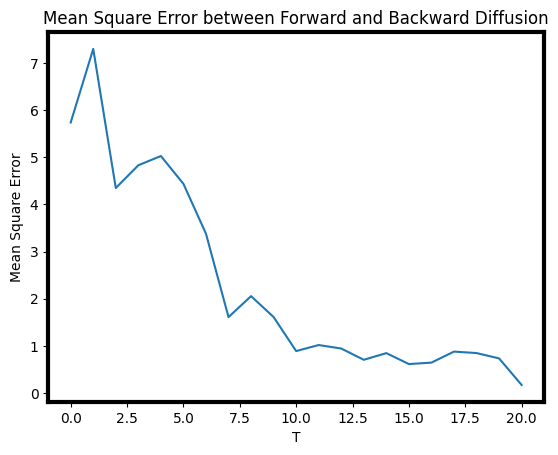

In [138]:
mse_calc = np.zeros((21, 16))
temp1 = Xout[0] * (T + 1) - np.sum(backwards_gen, axis = 1) / Ndata
for i in range(0, 21):
    for j in range(0, 16):
        val = temp1[i][j]
        mse_calc[i][j] =  np.abs(val) ** 2

mse_calc = np.abs(np.sum(mse_calc, axis = 1)) / 16

plt.plot(range(0, 21), mse_calc)
plt.title("Mean Square Error between Forward and Backward Diffusion")
plt.ylabel("Mean Square Error")
plt.xlabel("T")

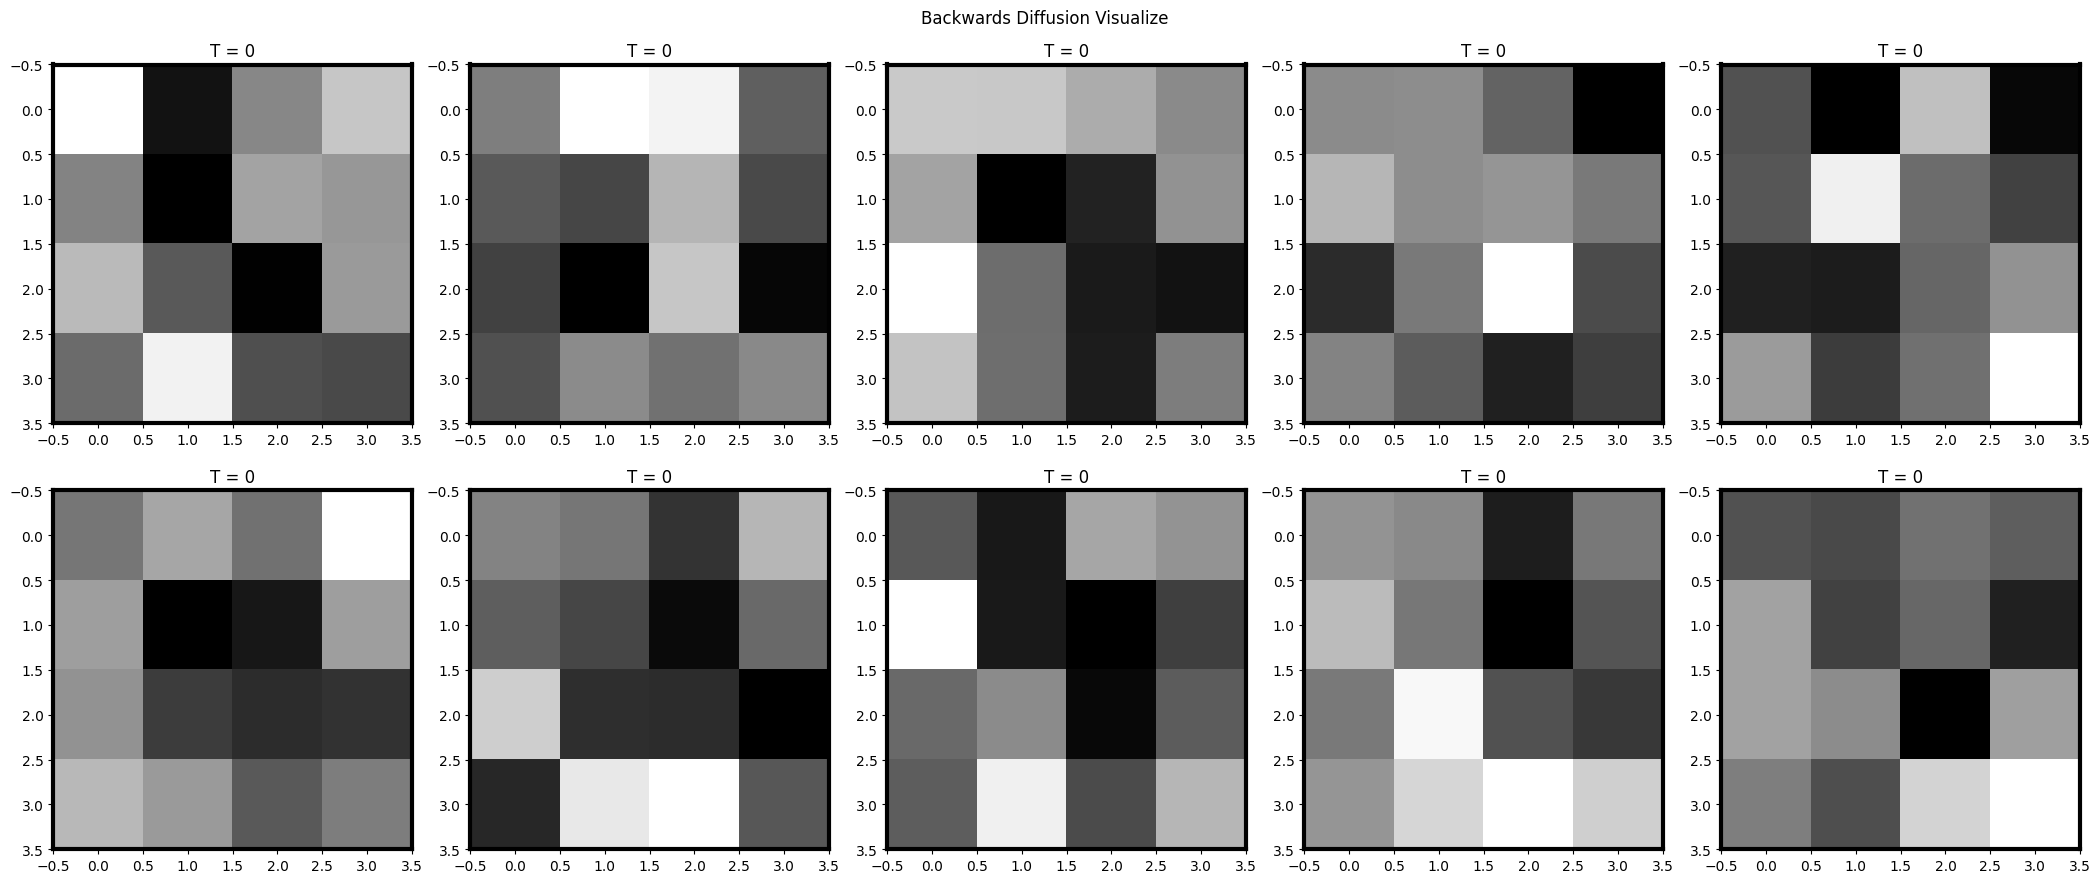

In [142]:
fig, axs = plt.subplots(2, 5, figsize = (21, 9))

for z in range(0, Ndata):
    #print(final_output_nxn[z])
    axs[int(z/5)][z%5].imshow(final_output_nxn[0][z], cmap = 'grey', interpolation = 'nearest')
    axs[int(z/5)][z%5].set_title('T = %d'%0)

plt.suptitle('Backwards Diffusion Visualize')
plt.tight_layout()
plt.show()